In [193]:
from common import *
disable_fig_save = False 
save_loc = 'plots'
save_prefix="pathfinding"
config_common(disable_fig_save=disable_fig_save, save_loc=save_loc, save_prefix=save_prefix)

from colors import *

In [194]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

%config InlineBackend.figure_format = 'svg'

from os import path
from typing import Dict, List, Set

import matplotlib.ticker as mtick
import matplotlib as mpl
from scipy.stats.mstats import gmean
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, ScalarFormatter, LogLocator)
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import rc

import seaborn as sns

In [195]:
init_notebook()
figsize = (7,1.65)
fontsize = 12
Fig.config(fontsize, figsize)

In [196]:
dataf_pmem = "../../data/linkedlist.pmem.csv"
dataf_gpu = "../../data/linkedlist.gpu.csv"

In [197]:
!sha256sum $dataf_pmem
!sha256sum $dataf_gpu

eb8267ee6c42f6c2e9dbb7580db386b65c813a74961ad6abd094ffce247e08ef  ../../data/linkedlist.pmem.csv
4dd61671411fb7501c0dddb5a76a11fcfb4cee48ff7a4e18a2d01352291b6a9b  ../../data/linkedlist.gpu.csv


In [198]:
df_pmem = pd.read_csv(dataf_pmem, index_col=None)
df_pmem = df_pmem.set_index('workload')
df_pmem = df_pmem/10**9

df_gpu = pd.read_csv(dataf_gpu, index_col=None)
df_gpu = df_gpu.set_index('workload')
df_gpu = df_gpu/10**9

In [199]:
df_pmem

,pmdk,snashot,msync
workload,,,
insert,0.444570,0.280422,185.355398
delete,0.439081,0.269353,124.655401
traverse,0.007857,0.001216,0.002194


In [200]:
df_gpu

,pmdk,snashot,msync
workload,,,
insert,16.138929,1.527864,NaN
delete,15.995313,0.883904,NaN
traverse,0.703281,0.000202,NaN


In [201]:
pmdk_col = df_pmem['pmdk']
df_pmem_norm = df_pmem.copy(deep=True)
# for col in df_pmem:
#     df_pmem_norm[col] = df_pmem[col]/pmdk_col
del df_pmem_norm['msync']
df_pmem_norm

,pmdk,snashot
workload,,
insert,0.444570,0.280422
delete,0.439081,0.269353
traverse,0.007857,0.001216


In [202]:
pmdk_col = df_gpu['pmdk']
df_gpu_norm = df_gpu.copy(deep=True)
# for col in df_gpu:
#     df_gpu_norm[col] = df_gpu[col]/pmdk_col
del df_gpu_norm['msync']
df_gpu_norm

,pmdk,snashot
workload,,
insert,16.138929,1.527864
delete,15.995313,0.883904
traverse,0.703281,0.000202


In [203]:
insert_dict = {
    'CXL': capitalize_index(df_gpu_norm.T)['Insert'],
    'PMEM': capitalize_index(df_pmem_norm.T)['Insert']
}

delete_dict = {
    'CXL': capitalize_index(df_gpu_norm.T)['Delete'],
    'PMEM': capitalize_index(df_pmem_norm.T)['Delete']
}

df_linear = pd.DataFrame({'Memory Type': [], 'Workload': [], 'Library': [], 'Execution Time (s)': []})
df_linear

for (mem_name, mem) in [('Emulated CXL', df_gpu_norm), ('PMEM', df_pmem_norm)]:
    for lib in ['pmdk', 'snashot']:
        for k, v in mem[lib].items():
            new_row = [mem_name, k, {'pmdk': 'PMDK', 'snashot': 'Snapshot'}[lib], v]
            df_linear.loc[-1] = new_row
            df_linear.index = df_linear.index + 1  # shifting index
df_linear

KeyError: 'Insert'

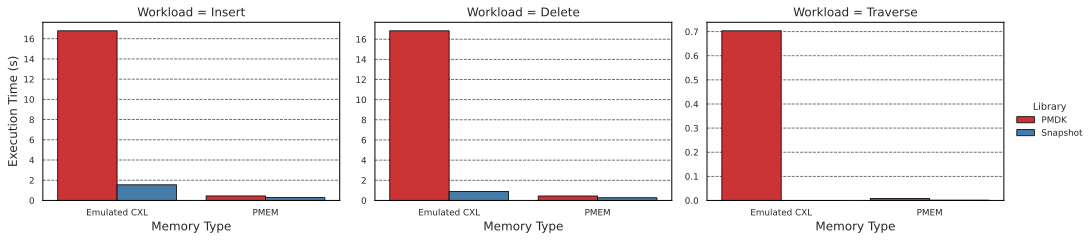

In [204]:
sns.set_context("paper", rc={"font.size":fontsize,"axes.titlesize":fontsize,"axes.labelsize":fontsize})   
sns.set_style('whitegrid')
sns.set_style(
    'whitegrid', 
    {"axes.facecolor": "1", 
     'axes.edgecolor': 'black', 
     "grid.color": "0.3", 
     "grid.linestyle": "--",  
     'patch.edgecolor': 'black', 
     'axes.linewidth': 1,
     'font.size': fontsize-10
    }
)

g = sns.catplot(
    x='Memory Type', y='Execution Time (s)', hue='Library', col='Workload',
    data=df_linear,
    kind='bar', 
    palette='Set1',
    sharey=False,
    height=figsize[1]*2,
    aspect=(figsize[0]/3)/float(figsize[1])
)
f = Fig(plt.gca())
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()

kwargs = {'bbox_inches': 'tight', 'dpi': 400, 'transparent': False, 'pad_inches': 0}
g.fig.savefig('plots/pathfinding/linkedlist.catplot.pdf', **kwargs)
g.fig.savefig('plots/pathfinding/linkedlist.catplot.png', **kwargs)

Plot saved as `plots/pathfinding/linkedlist.png`

'FreeSans.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved as `plots/pathfinding/linkedlist.png`

Using pdfcrop on `plots/pathfinding/linkedlist.png` with command `pdfcrop plots/pathfinding/linkedlist.pdf plots/pathfinding/linkedlist.pdf`

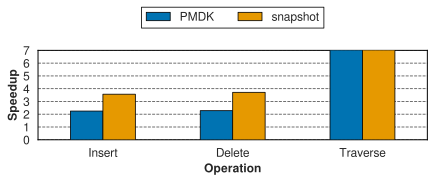

In [208]:
plt.rc('axes', unicode_minus=False)
mpl.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'freesans',
        'mathtext.fontset': 'stix',
    }
)

speedup = 1/df_pmem_norm
speedup = capitalize_index(speedup)
ax = rename_cols(speedup, {'pmdk': 'PMDK', 'snashot': 'snapshot', 'msync': 'msync'}).plot.bar(**Fig.get_kwargs())
f = Fig(ax)
f.fmt_legend()
f.fmt_label(u'Operation', 'Speedup')
f.add_bar_labels([False, False, False, False, False, False], precision=3, fontsize=fontsize-5, over_fig=False, alpha=0)
f.xrot(rot=0)
f.fmt_grid(axis='x', color='gray', linewidth=0.2)
ax.set_yticks(np.arange(0, 10, 1))
ax.set_ylim((0,7))
save_fig('linkedlist')